In [50]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm

In [51]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [52]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [53]:
def collect_best_records(
    path,                # e.g. "results/"
    solver,              # substring to match in filename
    reconstruction_algo  # another substring to match
):
    path = Path(path)
    group = {}

    # 1) gather all matching files into `group[name] = df`
    for file_path in path.iterdir():
        if not file_path.is_file():
            continue
        name = file_path.name
        if solver in name and reconstruction_algo in name:
            # parse_results should return a DataFrame
            group[name] = parse_results(file_path)

    # 2) error if nothing matched
    if not group:
        raise Exception(
            f"No files found in {path!r} containing "
            f"{solver!r} AND {reconstruction_algo!r}"
        )

    # 3) build a config dict for each name
    config = { name: get_config(name) for name in group }

    # 4) for each df, pick the row(s) with max score and merge in config
    best_slices = []
    for name, df in group.items():
        # select best‐score rows
        best_df = df[df['score'] == df['score'].min()].copy()

        # grab the config dict for this experiment
        conf = config[name]
        # turn it into a DataFrame with same index, then concat
        conf_df = pd.DataFrame([conf] * len(best_df), index=best_df.index)

        merged = pd.concat([best_df.reset_index(drop=True),
                            conf_df.reset_index(drop=True)],
                           axis=1)
        best_slices.append(merged)

    # 5) stitch all best‐records together
    result = pd.concat(best_slices, ignore_index=True)
    return result


In [ ]:
reconstruction_algo = "TF"
solver="Bayesian"

df_best = collect_best_records("results/", solver, reconstruction_algo)

In [55]:
def plot_score_scatter_by_params(
    df,
    x_param,
    y_param,
    annotate_cols=None,           # which df columns to show in the box
    annotate_markers=None,        # footnote symbols, e.g. ['1','2'] or [r'$\alpha$',r'$\beta$']
    col_labels=None,              # optional mapping { raw_col_name: "Pretty Name" }
    figsize=(8, 5),
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT"
):
    """
    Scatter plot of two hyperparams.  Points with min-x and min-y get little
    footnote markers, and on the right you see:

      marker:
         Pretty Col 1: value
         Pretty Col 2: value
    """
    annotate_cols    = annotate_cols    or []
    annotate_markers = annotate_markers or ['1','2']
    col_labels       = col_labels       or {}

    # --- styling (unchanged) ---
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman","Palatino","serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x_param], df[y_param], marker=marker, alpha=alpha)
    ax.set_title(title, pad=10)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    if df[x_param].nunique()>10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if df[y_param].nunique()>10:
        plt.setp(ax.get_yticklabels(), rotation=45, va='top')

    # locate the two “special” rows
    specials = [
        ('min x', df[x_param].idxmin()),
        ('min y', df[y_param].idxmin())
    ]

    # place superscript‐style markers just off each point
    for i, (_, idx) in enumerate(specials):
        x0, y0 = df.loc[idx, x_param], df.loc[idx, y_param]
        sym     = annotate_markers[i]
        ax.annotate(
            sym,
            xy=(x0,y0),
            xytext=(3,3),
            textcoords='offset points',
            fontsize=label_fontsize-2,
            ha='left', va='bottom'
        )

    # build the right-side info box
    info_lines = []
    for i, (label, idx) in enumerate(specials):
        sym = annotate_markers[i]
        # first line: just the marker + colon
        info_lines.append(f"{sym}:")
        # then each requested column underneath
        for col in annotate_cols:
            pretty = col_labels.get(col, col)
            val    = df.loc[idx, col]
            info_lines.append(f"    {pretty}: {val}")
        info_lines.append("")   # blank line to separate entries

    info_text = "\n".join(info_lines).rstrip()

    # make room on the right and drop the box in
    fig.subplots_adjust(right=0.75)
    ax.text(
        1.01, 0.5, info_text,
        transform=ax.transAxes,
        fontsize=label_fontsize-2,
        va='center', ha='left'
    )

    plt.tight_layout()
    plt.show()


In [56]:
if reconstruction_algo == "TF":
    annotate_cols=[
            "max_slope_x",
            "max_slope_y",
            "max_tol_x",
            "max_tol_y",
            "scatter"
        ] #TF

    col_labels = {
        'max_slope_x': r'$\Theta_x$',   # x‐slope angle
        'max_slope_y': r'$\Theta_y$',   # y‐slope angle
        'max_tol_x':   r'$\tau_x$',     # x‐tolerance
        'max_tol_y':   r'$\tau_y$',     # y‐tolerance
        'scatter':     r'$\sigma$'      # arbitrary scatter parameter
    } # TF
else:
    annotate_cols=[
            "min_strong_track_length",
            "allowed_missed_modules",
            "scatter"
        ] #ST

    col_labels = {
        'min_strong_track_length': r'$\ell_{\mathrm{strong}}^{\min}$',
        'allowed_missed_modules':   r'$n_{\mathrm{miss}}$',
        'scatter':                  r'$\sigma$'
    }


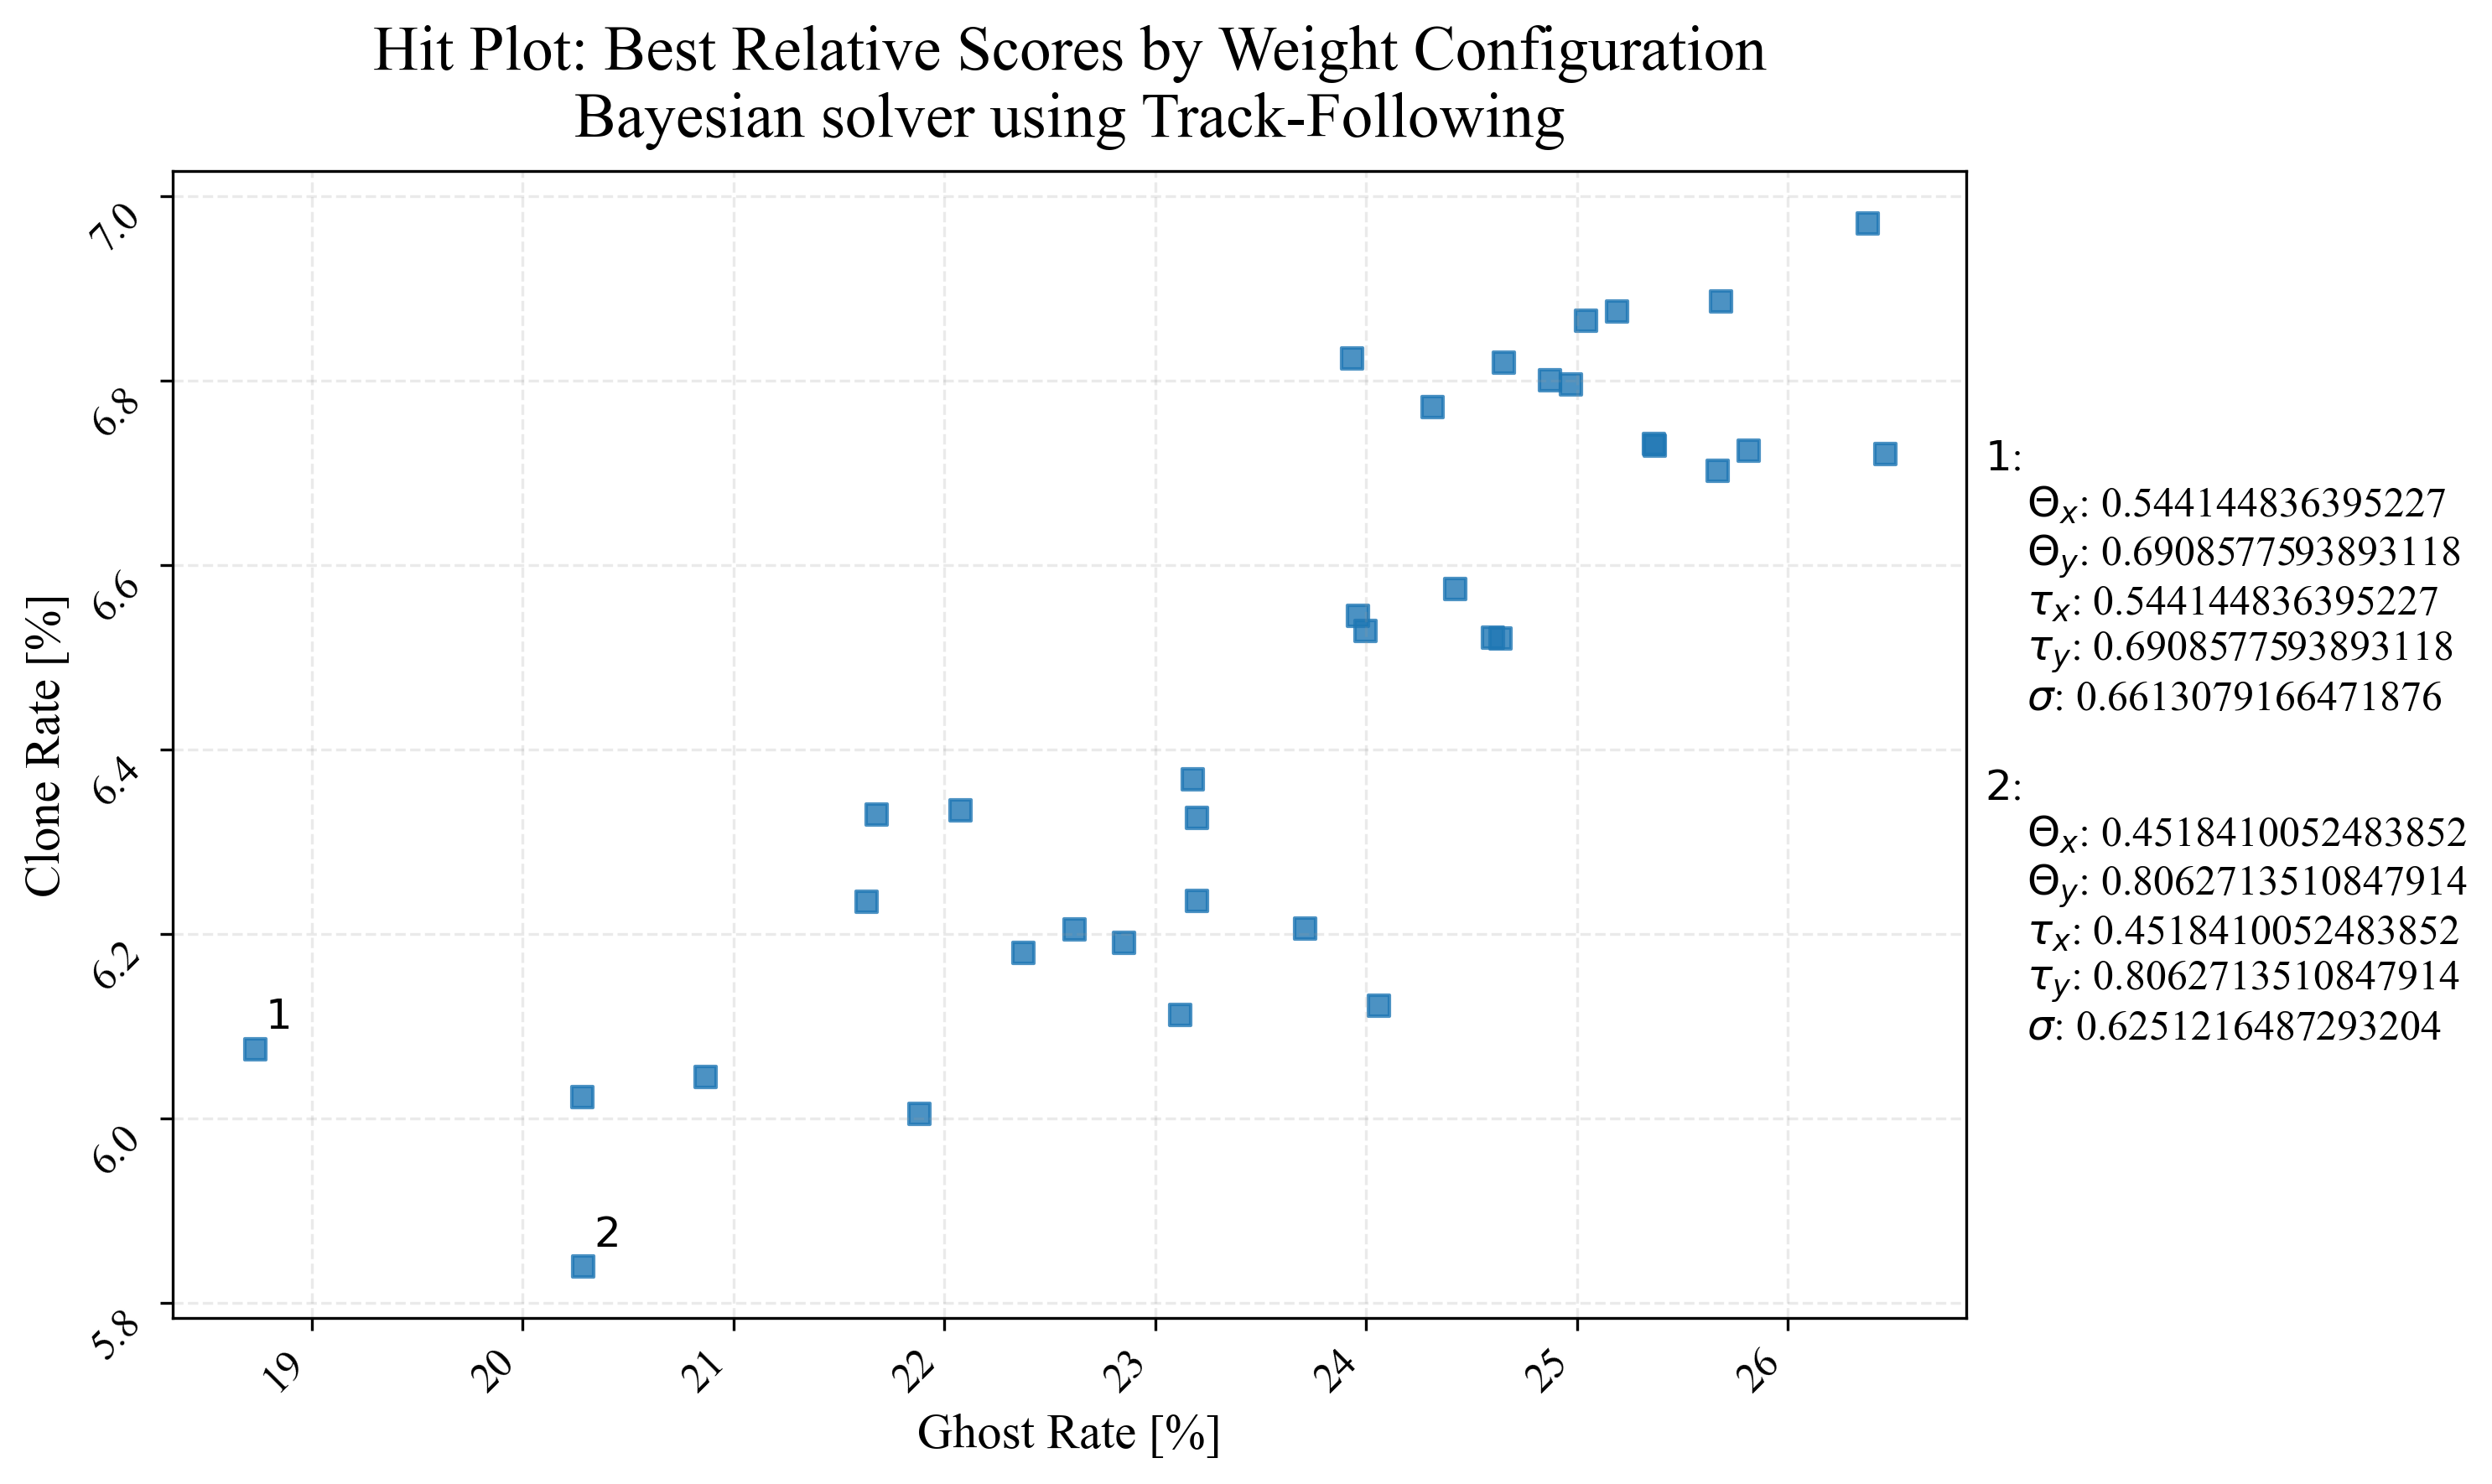

In [57]:
plot_score_scatter_by_params(
    df_best,
    x_param='event_avg_ghost_rate',
    y_param='clone_percentage',
    annotate_cols=[
        "max_slope_x",
        "max_slope_y",
        "max_tol_x",
        "max_tol_y",
        "scatter"
    ],
    col_labels=col_labels,
    annotate_markers=[r'$1$', r'$2$'],
    figsize=(10, 6),
    marker='s',
    title=f"Hit Plot: Best Relative Scores by Weight Configuration\n{solver} solver using {'Track-Following' if reconstruction_algo == 'TF' else 'Search-by-Triplet'}",
    XTitle="Ghost Rate [%]",
    YTitle="Clone Rate [%]"
)



In [58]:
df_best.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,max_slope_x,max_slope_y,max_tol_x,max_tol_y,scatter,solverName,num_events,intra_node,max_runs,optimizer,reconstruction_algo
0,f1a169c7-922e-4037-9ae5-2f1740e8ca48,-252486.763151,10161,28.168663,24.312390,6.771740,0.742207,0.573711,0.742207,0.573711,0.550920,Bayesian,100,True,21,"{'max_iterations': 21, 'objective': 'min', 'ne...",TF
1,517dd473-cefb-4e42-81cb-d2ea682e3cc8,-348246.661183,8172,23.465227,20.285434,5.839834,0.451841,0.806271,0.451841,0.806271,0.625122,Bayesian,100,True,21,"{'max_iterations': 21, 'objective': 'min', 'ne...",TF
2,d0d3a2d8-89c9-4405-b5e1-a11b4f22b866,-249521.776999,9106,25.544210,22.073980,6.334513,0.967926,0.838597,0.967926,0.838597,0.063824,Bayesian,100,True,21,"{'max_iterations': 21, 'objective': 'min', 'ne...",TF
3,bfd8a423-1504-47a7-bd8b-05ceed668e66,-362804.174237,10338,28.493468,24.601047,6.521790,0.742642,0.953192,0.742642,0.953192,0.256495,Bayesian,100,True,21,"{'max_iterations': 21, 'objective': 'min', 'ne...",TF
4,d1797d50-c0ec-4b7f-adb3-33f0d1791e5c,-250912.801155,9641,26.894859,23.196470,6.236202,0.658405,0.740103,0.658405,0.740103,0.238340,Bayesian,100,True,21,"{'max_iterations': 21, 'objective': 'min', 'ne...",TF
